In [4]:
import csv, sys
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

TOTAL_ROWS= 1972801
INPUT_ROWS_LIMIT= 1000000 # setting this over 1,000,000 causes a bug
FILENAME= 'dublinbikes_2020_Q1.csv'
MAX_STATION_ID= 117
SECS_IN_5MIN= 300
DATAPOINTS_PER_DAY= 288
MISSING_STATIONS= [117, 116, 70, 60, 46, 35, 20, 14, 1]
TOTAL_DAYS= 55
MAX_DISPLAYED_STATIONS= 1
MAX_DISPLAYED_DAYS= 5

class StationConstInfo: # this is a class to contain constant information about stations (so as to avoid unnecessary repeat reading of them)
    def __init__(self, station_id):
        self.station_id= station_id
        self.bike_capacity= -1 # populating with -1 initially as a debugging means
        self.address= -1
        self.latitude= -1
        self.longitude= -1
        
    def populate(self, station_name, bike_capacity, address, latitude, longitude):
        self.station_name= station_name
        self.bike_capacity= bike_capacity
        self.address= address
        self.latitude= latitude
        self.longitude= longitude

class StationVarInfo:
    def __init__(self, station_id):
        self.station_id= station_id
        self.data_days= [DataDay(i) for i in range(1, TOTAL_DAYS + 1)]

class DataDay:
    def __init__(self, day_id):
        self.day_id= station_id
        self.daily_epoch_time= []
        self.epoch_time= []
        self.percent_bikes_available= []
    
    def populate(self, daily_epoch_time, epoch_time, percent_bikes_available):
        self.daily_epoch_time.append(daily_epoch_time)
        self.epoch_time.append(epoch_time)
        self.percent_bikes_available.append(percent_bikes_available)

In [2]:
station_id= []; daily_epoch_time= []; epoch_time= []; percent_bikes_available= [];
station_consts= [StationConstInfo(i) for i in range(1, MAX_STATION_ID + 1)] # so MAX_STATION_ID + 1 is not included in the range
ids_to_populate= list(range(1, MAX_STATION_ID + 1))
for missing_id in MISSING_STATIONS:
    ids_to_populate.remove(missing_id)

with open(FILENAME, newline='') as f:
    reader = csv.reader(f); next(reader) # skip header
    current_id= 0
    try:
        while len(ids_to_populate) != 0:
            row= next(reader)
            if int(row[0]) == current_id: # this 'if' is just for performance
                continue
            current_id= int(row[0])
            if current_id in ids_to_populate:
                station_consts[current_id - 2].populate(row[3], row[4], row[8], row[9], row[10])
                ids_to_populate.remove(current_id)
        station_vars= [StationVarInfo(i) for i in range(1, MAX_STATION_ID + 1)]
        
        f.seek(0)
        reader= csv.reader(f); row= next(reader) # skip header
        for row_i, row in enumerate(reader):
            if row_i >= INPUT_ROWS_LIMIT:
                break
            epoch_time= int((datetime.datetime(int(row[1][0:4]), int(row[1][5:7]), int(row[1][8:10]), int(row[1][11: 13]), int(row[1][14: 16])) - datetime.datetime(2020,1,1,0,0)).total_seconds() / SECS_IN_5MIN) # the unit of this var is 5-minutes
            station_vars[int(row[0]) - 1].data_days[int(epoch_time / DATAPOINTS_PER_DAY)].populate( \
                int((datetime.datetime(int(row[1][0:4]), int(row[1][5:7]), int(row[1][8:10]), int(row[1][11: 13]), int(row[1][14: 16])) - datetime.datetime(int(row[1][0:4]), int(row[1][5:7]), int(row[1][8:10]), 0, 0)).total_seconds() / SECS_IN_5MIN), \
                epoch_time, \
                float("{:.3f}".format(float(row[6]) / float(row[4]))))
    except csv.Error as e:
        sys.exit('file {}, line {}: {}'.format(filename, reader.line_num, e))

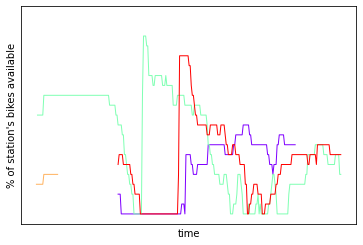

In [5]:
if MAX_DISPLAYED_DAYS < TOTAL_DAYS:
    colors= cm.rainbow(np.linspace(0, 1, MAX_DISPLAYED_DAYS))
else:
    colors= cm.rainbow(np.linspace(0, 1, TOTAL_DAYS))

for (day_i, day), c in zip(enumerate(station_vars[1].data_days), colors): # use day_i + 1 to access days because day 0 is empty but kept so that the day's date works as an array index too
    if day_i >= MAX_DISPLAYED_DAYS:
        break
    #plt.scatter(station.daily_epoch_time, station.percent_bikes_available, 1, marker="*", color= c, linewidth=0.0001)
    plt.plot(day.daily_epoch_time, day.percent_bikes_available, 1, color= c, linewidth=1)
plt.ylabel('% of station\'s bikes available')
plt.xlabel('time')
plt.xticks(())
plt.yticks(())

plt.show()

#plt.scatter(daily_epoch_time, percent_bikes_available,  color='black')